In [1]:
cd /home/makinen/repositories/IMNN_vs_BORG/

/home/makinen/repositories/IMNN_vs_BORG


In [2]:
import h5py
import jax
import jax.numpy as jnp
import optax

import flax.linen as nn
import numpy as np

import matplotlib.pyplot as plt

#from chainconsumer import ChainConsumer

import cloudpickle as pickle
import json

from nets import *
from imnn_mod import *
from utils import rotate_sim

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

def reshape_data(dat):
    realpart = dat[:, ::2, :, :]
    impart = dat[:, 1::2, :, :]

    return jnp.stack([realpart, impart], axis=-1)

In [3]:
config_path = "/data80/makinen/borg_sims_fixed/imnn_results/twoparam/configs.json"
with open(config_path) as f:
        configs = json.load(f)

savedir    = configs["savedir"]     # where to save shit
datadir    = configs["datadir"]     # where shit is saved
modeldir   = configs["modeldir"]
priordir   = configs["priordir"]
do_noise   = bool(configs["do_noise"])

In [4]:
### ------------- IMNN PARAMETERS -------------
θ_fid = jnp.array([0.3175, 0.800]) # CHANGE TO OmegaM=0.6
δθ = 2*jnp.array([0.05, 0.015])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))

n_summaries = 2

n_s = 1000
n_d = 250

n_params = 2
n_summaries = n_params

In [5]:
class ConvBlock(nn.Module):
    """Conv block submodule"""
    filters: int
    strides: int
    dims: int
    num_convs: int=3
    #input_shape: Sequence[int]

    @nn.compact
    def __call__(self, x):

        act = nn.swish

        x = nn.Conv(features=self.filters, kernel_size=(1,)*self.dims, strides=None)(x)
        #x = act(x1)
        x = nn.Conv(features=self.filters, kernel_size=(3,)*self.dims, strides=None)(x)
        #x = nn.LayerNorm()(x)
        x = act(x)
        #x += x
        x = nn.Conv(features=self.filters, kernel_size=(3,)*self.dims, strides=self.strides)(x)
        return x
           

In [6]:
class CNN_Unet(nn.Module):
    """An incept net architecture"""
    filters: int=4
    
    @nn.compact
    def __call__(self, x):
        act = nn.swish
        fs = self.filters

        dims = 3
        # do a shallow UNet

        x /= 0.005

        x1 = ConvBlock(fs, strides=(1,2,2), dims=dims)(x)
        x1 = act(x1)
        x2 = ConvBlock(fs, strides=(1,2,2), dims=dims)(x1)
        x2 = act(x2)
        x = ConvBlock(fs, strides=(1,2,2), dims=dims)(x2) # bottleneck
        x  = nn.ConvTranspose(features=fs, kernel_size=(3,3,3), strides=(1,2,2))(x)
        x  = jnp.concatenate([x,x2], -1)
        x  = nn.ConvTranspose(features=fs, kernel_size=(3,3,3), strides=(1,2,2))(x)
        x  = jnp.concatenate([x, x1], -1) # back to original resolution

        x = ConvBlock(fs, strides=4, dims=3)(x) # down to 8
        x = act(x)
        x = ConvBlock(fs, strides=4, dims=3)(x) # down to 2
        x = act(x)
        x = ConvBlock(fs, strides=2, dims=3)(x) # down to 1
        x = act(x)
        x = nn.Conv(features=n_params, kernel_size=(1,)*dims, strides=None)(x)
        x = x.reshape(-1)
        return x

In [7]:
class CNN_Unet2(nn.Module):
    """An incept net architecture"""
    filters: int=4
    
    @nn.compact
    def __call__(self, x):
        act = nn.swish
        fs = self.filters

        dims = 3
        # do a shallow UNet

        x /= 0.005

        x1 = ConvBlock(fs, strides=(1,2,2), dims=dims)(x)
        x1 = act(x1)
        x2 = ConvBlock(fs, strides=(1,2,2), dims=dims)(x1)
        x2 = act(x2)
        x3 = ConvBlock(fs, strides=(1,2,2), dims=dims)(x2)
        x3 = act(x3)
        x  = ConvBlock(fs, strides=(1,2,2), dims=dims)(x3) # bottleneck
        x  = nn.ConvTranspose(features=fs, kernel_size=(3,3,3), strides=(1,2,2))(x)
        x  = jnp.concatenate([x,x3], -1)
        x  = nn.ConvTranspose(features=fs, kernel_size=(3,3,3), strides=(1,2,2))(x)
        x  = jnp.concatenate([x,x2], -1)
        x  = nn.ConvTranspose(features=fs, kernel_size=(3,3,3), strides=(1,2,2))(x)
        x  = jnp.concatenate([x, x1], -1) # back to original resolution

        x = ConvBlock(fs, strides=4, dims=3)(x) # down to 8
        x = act(x)
        x = ConvBlock(fs, strides=4, dims=3)(x) # down to 2
        x = act(x)
        x = ConvBlock(fs, strides=2, dims=3)(x) # down to 1
        x = act(x)
        x = nn.Conv(features=n_params, kernel_size=(1,)*dims, strides=None)(x)
        x = x.reshape(-1)
        return x

In [8]:
filters

(16, 16, 16, 16)

In [9]:

### ------------- NEURAL NETWORK MODEL -------------

filters = (int(configs["filters"]),)*4

net_scaling = 0.001
patience = configs["patience"]
noise_scale = configs["noise_scale"]
act = "almost_leaky" #configs["act"]




model = CNN_Unet2(filters=10)

key = jax.random.PRNGKey(42)

input_shape = (4, 64, 64, 2)

### ------------- DEFINE DATA AUGMENTATION SCHEME -------------
### ADD IN NOISE ON TOP OF FIELD SIMS
### NOISE VARIANCES == SIGMA^2

#if do_noise:
noise_variances = jnp.array([1.79560224e-06, 5.44858988e-06, 9.45448781e-06, 1.32736252e-05])
    
#noise_variances /= 3.
#else:
#    noise_variances = jnp.array([0., 0., 0., 0.])

@jax.jit
def noise_simulator(key, sim):
    key1,key2 = jax.random.split(key)
    # do rotations of simulations
    k = jax.random.choice(key1, jnp.array([0,1,2,3]), shape=())
    sim = rotate_sim(k, sim)

    # now add noise
    # this generates white noise across all pixels and then increases the amplitude
    # add zero noise for no-noise case
    sim += (jax.random.normal(key2, shape=(4,64,64,2)) * noise_scale * jnp.sqrt(noise_variances).reshape(4,1,1,1))
    return sim


#### ------------- SET UP IMNN -------------

optimiser = optax.adam(learning_rate=1e-4)

model_key = jax.random.PRNGKey(42)
rng, key = jax.random.split(key)

shape = (4, 64, 64, 2)

w = model.init(model_key, jax.random.normal(key, shape=shape))

In [10]:
output = model.apply(w, jax.random.normal(key, shape=shape))
output

DeviceArray([-0.26818207, -0.01885008], dtype=float32)

In [44]:
np = jnp

In [45]:
priordir

'/data80/makinen/borg_sims_fixed/prior_data/'

In [11]:
# now do regression over prior with IMNN weights to hone in on OmegaM

X = jnp.load(priordir + "noisefree_prior_sims.npy")
y = jnp.load(priordir + "noisefree_prior_params.npy")


X = reshape_data(X)[:, :, :, :, :]
#x = np.load("/data80/makinen/borg_sims/x_imnn.npy")
#estimates = np.array([[0.34354842, 0.7942477 ]])

In [12]:
from sklearn.model_selection import train_test_split

Xt = jax.device_put(X)
yt = jax.device_put(y)
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, random_state=0, test_size=2000)

keys = jax.random.split(jax.random.PRNGKey(88), num=X_test.shape[0])
X_test = jax.vmap(noise_simulator)(keys, X_test)

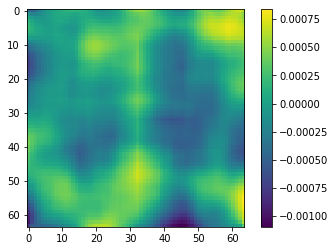

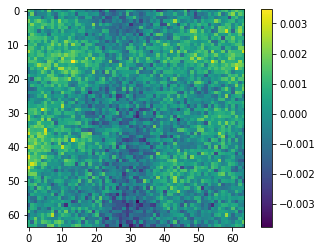

In [48]:
plt.imshow(Xt[0, 0, :, :, 0])
plt.colorbar()
plt.show()
plt.imshow(X_test[0, 0, :, :, 0])
plt.colorbar()
plt.show()

In [16]:
# load weights

w = load_obj()

In [13]:
# initialize stuff

def mynet(w, d):
    """function to set weights and use get_estimate function for regression"""
    #IMNN.set_F_statistics(w, key=key)
    return model.apply(w, d)  #

In [15]:
@jax.jit
def mse(w, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def squared_error(x, y):
    pred = mynet(w, x)
    return (jnp.inner(y-pred, y-pred) / 2.0)
  # Vectorize the previous to compute the average of the loss on all samples.
  return (jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0))

In [64]:
from tqdm import tqdm
import optax

tx = optax.adam(learning_rate=1e-3)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(mse)

batch_size = 250
epochs = 200

modelname = "reg_w_033_var"

losses = []
val_losses = []

key = jax.random.PRNGKey(99)

best_val_loss = jnp.inf

In [110]:
tx = optax.adam(learning_rate=5e-6)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(mse)

In [18]:
regmodeldir = "/data80/makinen/borg_sims_fixed/regression_weights/"

import pathlib
pathlib.Path(regmodeldir).mkdir()

FileExistsError: [Errno 17] File exists: '/data80/makinen/borg_sims_fixed/regression_weights'

In [111]:
pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
  key,rng = jax.random.split(key)

  for i in range(len(X_train) // batch_size):
    x_samples = X_train[batch_size*i:(batch_size*(i+1))]
    y_samples = y_train[batch_size*i:(batch_size*(i+1))]

    keys = jax.random.split(key, num=batch_size)
    x_samples = jax.vmap(noise_simulator)(keys, x_samples)

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)
    if i % 10 == 0:

      val_loss, _ = loss_grad_fn(w, X_test, y_test)
      #print('loss step {}: '.format(i), loss_val)
      #print('val loss step {}: '.format(i), val_loss_val)

  if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_obj(w, regmodeldir + modelname)
  
  losses.append(loss_val)
  val_losses.append(val_loss)
  pbar.set_description('epoch loss %d: %.4f, val loss: %.4f'%(j, loss_val, val_loss))

epoch loss 21: -5.3639, val loss: -5.4019:  11%|█         | 22/200 [06:01<48:47, 16.45s/it]

KeyboardInterrupt: 

In [76]:
np.exp(-4)

DeviceArray(0.01831564, dtype=float32, weak_type=True)

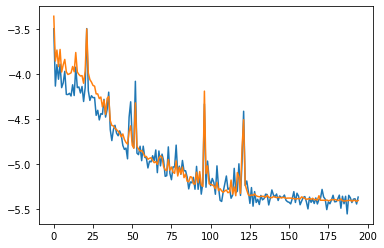

In [112]:
plt.plot(losses)
plt.plot(val_losses)
#plt.yscale('log')

In [106]:
import gc
gc.collect()

922

In [113]:
_mynet = lambda d: mynet(w, d)

num = 2000

keys = jax.random.split(key, num=num)
#noisedat = jax.vmap(noise_simulator)(keys, X_test)
x = jax.vmap(_mynet)(X_test)

ytest = y_test



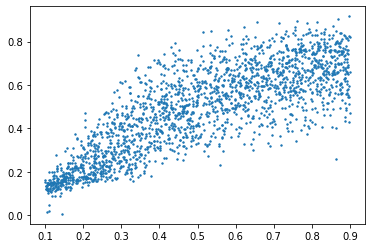

In [114]:
#plt.scatter(y[:2500, 0], xold[:, 0], s=2)
plt.scatter(ytest[:, 0], x[:, 0], s=2)
#plt.ylim(-1, 2)

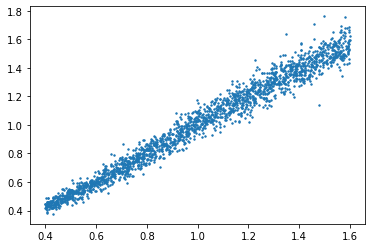

In [115]:
#plt.scatter(y[:2500, 1], xold[:, 1], s=2)
plt.scatter(ytest[:, 1], x[:, 1], s=2)
#plt.ylim(0, 3)

In [57]:
cd /home/makinen/repositories/alfi_lensing/

/home/makinen/repositories/alfi_lensing


In [101]:
pwd

'/home/makinen/repositories/IMNN_vs_BORG'

In [116]:
np.save("/home/makinen/repositories/alfi_lensing/regression_x", x)
np.save("/home/makinen/repositories/alfi_lensing/regression_theta", ytest)

In [102]:
np.save("/home/makinen/repositories/alfi_lensing/regression_x", x[-2500:])
np.save("/home/makinen/repositories/alfi_lensing/regression_theta", y[-2500:])

In [100]:
y[-2500:, 0].min()

DeviceArray(0.10099613, dtype=float32)

In [91]:
save_obj(w, '/data80/makinen/borg_sims/regression_net_w_log')

In [117]:
#### ------------- get Natalia's target data WITH NOISE -------------
print("loading mock data for obtaining estimates")

import numpy as onp
np = onp
import h5py as h5



def get_data(f):
	dataR = np.zeros((4, 64, 64))
	dataI = np.zeros((4, 64, 64))

	bin0 = f['tomo0'][:]
	bin1 = f['tomo1'][:]
	bin2 = f['tomo2'][:]
	bin3 = f['tomo3'][:]

	data = np.stack([bin0,bin1,bin2,bin3])

	dataR = np.real(data)
	dataI = np.imag(data)

	return dataR, dataI


path = configs["target_path"] 
f = h5.File(path + 'mock_data/mock_data_fields.h5', 'r')

targetR, targetI = get_data(f)

_dat = onp.ones((8, 64, 64))
_dat[::2, :, :] = targetR
_dat[1::2, :, :] = targetI

np=jnp
_dat = jnp.array(_dat)


target_data = jnp.squeeze(reshape_data(_dat[jnp.newaxis, :, :, :]))

target_data = noise_simulator(jax.random.PRNGKey(99), target_data)

loading mock data for obtaining estimates


In [118]:
_mynet(target_data)

DeviceArray([0.19964892, 0.8037524 ], dtype=float32)

In [28]:
np.save('/data80/makinen/borg_sims/natalia_target_data', jnp.squeeze(target_data))